<div align="center">

# Preprocessing Petawawa Research Forest Data

### Author: Harry Seely

</div>

![prf_image](https://opendata.nfis.org/mapserver/PRF_Layout.jpg)

This notebook provides python code to preprocess the Petawawa Research Forest (PRF) inventory and ancillary datasets.

All data is sourced from the following website: 

https://opendata.nfis.org/mapserver/PRF.html

Please consult this page to get the most up to date version of the PRF data.

## Table of Contents

1. Python environment setup

2. Load Packages

3. Download Data

4. Clean Data

5. Export Data

## Python Environment Setup <a class="anchor" id="env-setup"></a>

This tutorial is offered in Google Collab format primarily, but can also be run locally using jupyter notebooks.

**Environment setup is performed using the [uv package manager](https://docs.astral.sh/uv/) which will need to be installed to run the code.**

The uv package manager allows for the installation of specific package versions to maintain reproducibility. The list of packages and their versions is included in the `pyproject.toml` file. Read more about using PyTorch with uv in this [documentation](https://docs.astral.sh/uv/guides/integration/pytorch/).

**This code has been tested on Windows 11**

1. Open a terminal and check that uv is installed by running 

    ```
    uv
    ```

2. Ensure uv is up-to-date by running

    ```
    uv self update
    ```

3. Intialize the uv environment and install dependencies.

    ```
    uv sync
    ```

 ## Load Packages <a class="anchor" id="load-packages"></a>

In [64]:
import os
import pandas as pd
import geopandas as gpd
import requests, zipfile, io
import zipfile

## Download Data <a class="anchor" id="download-data"></a>

In [65]:
# Whether to download data (only needs to be done once, but takes a while)

DOWNLOAD_DATA = True

url_dict = {

'prf_boundary': r"https://opendata.nfis.org/downloads/petawawa/Vector/Boundaries/prf_boundary.zip",

'plot_data': r"https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/SPL2018_EFI_ground_plots.zip",

'lidar_rasters': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/PRF_LiDAR2018_Predictors.zip",

# 'dtm': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/prf_spl2018_dtm_50cm_wgs84.zip",

}

url_dict

{'prf_boundary': 'https://opendata.nfis.org/downloads/petawawa/Vector/Boundaries/prf_boundary.zip',
 'plot_data': 'https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/SPL2018_EFI_ground_plots.zip',
 'lidar_rasters': 'https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/PRF_LiDAR2018_Predictors.zip'}

In [66]:
def download_zip(url, outdir):

    r = requests.get(url)

    z = zipfile.ZipFile(io.BytesIO(r.content))

    z.extractall(outdir)

    print(f"{os.path.basename(url)} downloaded to:\n{outdir}")

    

In [67]:
data_dir = 'data'

# Create a directory to store the data
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [68]:
if DOWNLOAD_DATA:
    
    for key, url in url_dict.items():   

            print(f"Downloading {key}...")

            download_zip(url, data_dir)

# Check files in data directory
downloaded_ls = os.listdir(data_dir)
print(downloaded_ls)


prf_boundary.zip downloaded to:
data
SPL2018_EFI_ground_plots.zip downloaded to:
data
PRF_LiDAR2018_Predictors.zip downloaded to:
data
['prf_boundary', 'prf_spl2018_dtm_50cm_wgs84.tif', 'SPL2018_EFI_ground_plots', 'SPL2018_EFI_predictors']


## Clean Data <a class="anchor" id="clean-data"></a>

In [69]:
# PRF Boundary

boundary_gdf = gpd.read_file(os.path.join(data_dir, 'prf_boundary/prf_boundary.shp'))

In [70]:
# Read plot data

plots_fpath = 'data/SPL2018_EFI_ground_plots/PRF_SPL2018_EFI_plots_pts_wgs84.shp'

plots_gdf = gpd.read_file(plots_fpath)

plots_gdf

,Plot,Date,Northing,Easting,Source,geometry
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0)
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0)
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0)
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0)
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0)
...,...,...,...,...,...,...
244,PRF187,November 22 2018,5091476.078,308950.650,Topcon Hiper V PPP,POINT Z (308950.451 5091477.093 0)
245,PRF209,October 19 2018,5091851.419,312997.322,Topcon Hiper V PPP,POINT Z (312997.124 5091852.434 0)
246,PRF214,October 6 2018,5091627.257,312973.063,Topcon Hiper V PPP,POINT Z (312972.865 5091628.272 0)
247,PRF149,October 25 2018,5090277.081,301422.935,Topcon HiperSR PPP,POINT Z (301422.735 5090278.095 0)


**Tree Data Dictionary**

| **Column**      | **Definition**                                                                 |
|------------------|-------------------------------------------------------------------------------|
| PlotName         | Plot name                                                                    |
| TreeID           | Tree ID                                                                      |
| TreeSpec         | Tree species                                                                 |
| Origin           | Origin. N = natural (includes coppice), P = planted                          |
| Status           | Status. L = Live, D = Dead (only includes decayclass 1 & 2)                  |
| DBH              | Dbh (cm)                                                                     |
| CrownClass       | Crown class                                                                  |
| QualityClass     | Quality class                                                                |
| DecayClass       | Decay class                                                                  |
| Ht               | Height (m), includes estimated heights                                       |
| HLF              | HLF                                                                          |
| HtFlag           | HtFlag                                                                       |
| baha             | Basal area/ha = Dbh * Dbh * 0.00007854 * stems                               |
| ht_meas          | Height (m), if measured in the field                                         |
| stems            | Stems per hectare (number of trees/ha each tree represents)                  |
| mvol             | Gross merchantable volume (m³/ha)                                            |
| tvol             | Gross total volume (m³/ha)                                                  |
| biomass          | Aboveground biomass (kg/ha)                                                 |
| size             | Sawlog size                                                                  |

In [71]:
# Load and explore tree data

trees_fpath = r"data/SPL2018_EFI_ground_plots/PRF_CNL_SPL_CalibrationData_LiveDeadStems.xlsx"

trees_df = pd.read_excel(trees_fpath, sheet_name="Tree")

trees_df

,tree_spec,PlotName,TreeID,TreeSpec,Origin,Status,DBH,CrownClass,QualityClass,DecayClass,...,BA_all,TPH_all,codom,domht,ht_meas,stems,mvol,tvol,biomass,size
0,1,PRF001,24.0,1,P,D,10.1,NaN,NaN,1.0,...,33.601655,2688,N,12.223077,NaN,16,0.000000,0.708735,393.396400,Poles
1,1,PRF001,46.0,1,P,D,9.9,NaN,NaN,2.0,...,33.601655,2688,N,12.223077,NaN,16,0.000000,0.673254,375.305379,Poles
2,2,PRF001,20.0,2,N,L,67.5,D,A,NaN,...,33.601655,2688,Y,33.433333,33.9,16,77.327438,79.482658,39691.639950,Large
3,2,PRF001,50.0,2,N,L,57.9,D,U,NaN,...,33.601655,2688,Y,33.433333,NaN,16,56.444281,58.117292,28251.255888,Large
4,1,PRF001,10.0,1,N,L,55.9,D,A,NaN,...,33.601655,2688,Y,33.433333,33.0,16,48.008649,49.833743,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,30,PRF334,NaN,30,N,L,3.7,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,NaN,200,0.000000,0.858564,851.191939,Under
12586,30,PRF334,NaN,30,N,L,3.3,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,8.5,200,0.000000,0.653868,659.084439,Under
12587,30,PRF334,NaN,30,N,L,3.2,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,NaN,200,0.000000,0.607493,615.333049,Under
12588,30,PRF334,NaN,30,N,L,3.0,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,7.4,200,0.000000,0.469656,521.064025,Under


## Make a map of PRF Plots

In [72]:
import geopandas
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt

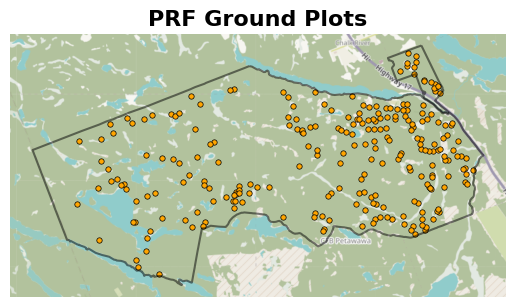

In [73]:
# Convert to web mercator for plotting
plots_gdf_wm = plots_gdf.to_crs(epsg=3857)

ax = plots_gdf_wm.plot(facecolor="orange", 
                       edgecolor='black',
                       markersize=15,
                       linewidth=0.5)

boundary_gdf.to_crs(epsg=3857).plot(ax=ax, 
                                    color='none', 
                                    edgecolor='black', 
                                    linewidth=1.5,
                                    alpha=0.5)

cx.add_basemap(ax, attribution='')

# Remove axis labels and ticks
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Add title
ax.set_title("PRF Ground Plots", fontsize=16, fontweight='bold', loc='center')

# Save plot to file
plt.savefig("prf_ground_plots_map.png", dpi=300, bbox_inches='tight')



 ## Export and Compress Data <a class="anchor" id="export"></a>

In [74]:
trees_out_fpath = 'trees.csv'

plots_out_fpath = 'plots.gpkg'

trees_df.to_csv(trees_out_fpath, index=False)

plots_gdf.to_file(plots_out_fpath, driver='GPKG', index=False)

In [75]:
# Zip data so it can be uploaded to google drive

zip_file_name = 'prf_data.zip'

files_to_compress = [trees_out_fpath, plots_out_fpath]

zip_object = zipfile.ZipFile(zip_file_name, 'w')

for file_name in files_to_compress:
    zip_object.write(file_name, compress_type=zipfile.ZIP_DEFLATED)

zip_object.close()

print(f"Data zipped to {zip_file_name}")

Data zipped to prf_data.zip


In [76]:
# Remove unzipped files
for file_name in files_to_compress:
    os.remove(file_name)